# [In Progress]

# Programación Entera: Heurísticas para el Problema de la Mochila

#### Descripción

TODO

#### Autor
  
  * Sergio García Prado - [garciparedes.me](https://garciparedes.me)
  
#### Fecha

  * Mayo de 2018


## Contenidos
  * [Introducción](#Introducción)
  * [Problema de la Mochila](#Problema-de-la-Mochila)
    * [Mochila Simple](#Mochila-Simple)
    * [Mochila Múltiple](#Mochila-Múltiple)
    * [Mochila Multidimensional](#Mochila-Multidimensional)
  * [Problema de Empaquetamiento](#Problema-de-Empaquetamiento)
    * [Empaquetamiento Unidimensional](#Empaquetamiento-Unidimensional)
  * [Conclusiones](#Conclusiones)

## Introducción

El estudio de problemas de programación lineal permite descubrir técnicas eficientes para la búsqueda del valor óptimo de un problema con restricciones. Dicha búsqueda permite en muchos casos reducir costes e incrementar beneficios en un gran número de campos, tales como en Ingeniería, Finanzas, Planificación de Tareas, etc. 

Existe un conjunto de problemas basados en la búsqueda de la configuración óptima para el transporte de mercancías, de tal manera que se aproveche al máximo el espacio disponible. Existen dos problemas elementales en dichas situaciones: siendo el primero de ellos el de elegir un subconjunto de productos de entre un conjunto mayor, de tal manera que se maximice el valor de los mismos condicionado a unas restricciones de espacio (**Problema de la Mochila**), y el segundo problema en el que suponemos espacio un número ilimitado de contenedores, pero tratamos de utilizar la menor cantidad de estos, de tal manera que cada uno de ellos se aproveche al máximo posible (**Problema de Empaquetamiento**). 

Es fácil darse cuenta de la gran capacidad de modelización de este tipo de problemas, que en primera instancia pueden ser utilizados para el sector de transporte (para aprovechar al máximo el tamaño de los camiones). Sin embargo, puede aplicarse a otros contextos diferentes, como el aprovechamiento máximo de equipos de trabajo de tal manera que estos realicen de manera prioritaria aquellas tareas con más valor, o el número de trabajadores necesarios para completar un conjunto de tareas de trabajo (sin dependencias de orden).

Por tanto, en este trabajo se estudian y analizan en detalle los problemas de la mochila y empaquetamiento, para conocer en detalle los modelos matemáticos subyacentes. Además, se estudian heurísticas de resolución para estos problemas, que a pesar de no garantizar soluciones óptimas, permiten suministrar soluciones muy cercanas a dichos valores utilizando un coste computacional mucho menor. 


El resto del documento se organiza por tanto de la siguiente manera. En primera instancia se indican distintas variables de configuración, así como funciones de apoyo que se utilizarán a lo largo del trabajo. Posteriormente se estudiará el problema de la Mochila, en tres de sus variantes (simple, multiple y multidimensional) proporcionando la implementación del modelo exacto y su relajación lineal, así como diferentes heurísticas aproximadas. A continuación se presenta el problema de empaquetamiento, para el cual se define el modelo exacto, pero debido al elevado coste computacional que genera, tan solo se ha implementado una heurística que proporciona resultados muy cercanos a la optimalidad. Por último, se concluye el trabajo con distintas conclusiones acerca de este tipo de problemas.

#### Configuración del Entorno

In [1]:
rm(list = ls())

In [2]:
library(slam, warn.conflicts = FALSE)
library(Rglpk, warn.conflicts = FALSE)
library(purrr, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(magrittr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggthemes, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)

Using the GLPK callable library version 4.65


In [3]:
options(repr.matrix.max.rows = 600, repr.matrix.max.cols = 600)

#### Constantes y Funciones de Apoyo

A continuación se definen un conjunto de constantes referidas a las distintas rutas en que se localizan los ficheros, así como las funciones que permiten la lectura apropiada de los distintos problemas que se utilizarán como ejemplos de prueba en el documento:

In [4]:
dataset.root <- "./data/"
dataset.folder <- paste0(dataset.root, "knapsack/")
dataset.folder.simple <- paste0(dataset.folder, "simple/")
dataset.folder.multi  <- paste0(dataset.folder, "multidimensional/")
dataset.folder.binpacking <- paste0(dataset.root, "binpacking/")

In [5]:
ReadSimpleKnapsack <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]") %>%
        unlist() %>%
        as.double()
    close(con)
    list(
        n        = raw[1],
        capacity = raw[2] ,
        value    = raw[seq(4, length(raw), by = 3)],
        weight   = raw[seq(5, length(raw), by = 3)]
    ) %>%
    return()
}

In [6]:
ReadMultidimensionalKnapsack <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]") %>%
        unlist() %>%
        as.double()
    close(con)
    list(n        = raw[1],
         m        = raw[2],
         objval   = raw[3],
         value    = raw[4:(raw[1]+ 3)],
         weight   = matrix(raw[(4 + raw[1]):(3 + raw[1] * (1 + raw[2]))], 
                           ncol = raw[1], byrow = TRUE),
         capacity = raw[(4 + raw[1] * (1 + raw[2]) ):length(raw)]
    ) %>%
    return()
}

In [7]:
ReadBinPacking <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]") %>%
        unlist()
    close(con)
    
    name <- raw[1]
    raw.numeric <- 
        raw[2:length(raw)] %>%
        as.double()

    list(name     = name,
         capacity = raw.numeric[1],
         n        = raw.numeric[2],
         objval   = raw.numeric[3],
         size     = raw.numeric[4:length(raw.numeric)]
    ) %>%
    return()
}

A continuación se indica la función que se encarga de la resolución de los problemas de programación lineal de manera exacta, la cual consiste en un wrapper que utiliza el solver *GLPK*:

In [8]:
Solve <- function(...) {
    Rglpk_solve_LP(...)
}

Para la resolución de distintos problemas es necesario obtener el subproblema de la mochila, esto es selecionar un subconjunto de productos de entre los iniciales (esto se utilizará en la resolución del problema de la mochila múltiple por métodos heurísticos tal y como veremos en futuras secciones). La función que realiza dicha tarea se define a continuación:

In [9]:
SimpleKnapsackSubSet <- function(p, selected, capacity = p$capacity){
    if (sum(selected) > 0) {
       list(n        = sum(selected),
            capacity = capacity,
            value    = p$value[selected],
            weight   = p$weight[selected]
        ) %>%
        return()
    }
}

Una vez definidas introducido el contenido del trabajo, además de haber definidido las funciones de apoyo necesarias para trabajar con los distintos problemas de ejemplo, ya se puede comenzar el análisis de los modelos de programación lineal entera y binaria en los que se basa el trabajo. Primeramente hablaremos del *Problema de la Mochila* para posteriormente centrarnos en el *Problema de Empaquetamiento*

## Problema de la Mochila

#### Descripción

Tal y como se ha indicado brevemente en la introducción del trabajo, el *problema de la mochila* consiste en la búsqueda de la selección óptima de productos cuantificada a partir de una función de beneficio y restringida a unas determinadas condiciones de espacio. Dicha configuración se puede llevar a cabo mediante distintos criterios, siendo utilizados comunmente el de minimización o maximización del valor total (aunque existen otras alternativas). Dado que en este caso, todos los problemas de ejemplo tratan de maximizar el valor del  contenedor, definiremos todos los modelos utilizando este criterio de optimalidad.

Para definir el problema de la mochila de manera general, es necesario es necesario conocer cierta información acerca del mismo. Para ello, necesitamos un conjunto de productos, para los cuales cada uno debe tener definido un determinado valor, así como un determinado peso o espacio. En cuanto al contenedor, deberemos conocer el peso o espacio máximo que este puede contener. 

A partir de estos valores, se trata de ajustar el listado de productos que introduciremos en el contenedor, de tal manera que la suma del valor valor de los productos sea máxima. Este problema es por tanto un problema de decisión binaria en el cual para cada producto se decide, si este pertenecerá al conjunto de productos seleccionados o no.

Una vez entendido el sentido del problema de la mochila, en los siguientes apartados se presentan distintas caracterizaciones del mismo. Estas son: el problema de la [Mochila Simple](#Mochila-Simple), el de la [Mochila Múltiple](#Mochila-Múltiple) y el de la [Mochila Multidimensional](#Mochila-Multidimensional). Cada uno de ellos es acompañado por un grupo de ejercicios para demostrar la validez de los métodos implementados.

### Mochila Simple

#### Descripción

El *problema de la mochila simple* es la versión más simplificada posible, dado que tan solo se tiene un contenedor, con un determinado tamaño, al cual denotaremos por $c$ y definiremos como capacidad del mismo. El conjunto de posibles productos candidatos es de tamaño $n$ y cada uno de ellos está compuesto por una tupla que indica su valor y su peso. Esto se puede entender diciendo que la tupla $(p_j, w_j)$ representa al producto $j$-ésimo. Puesto que estamos ante un problema de decisión, es necesario definir tantas variables de decisión, de carácter binario, como productos posibles haya disponibles. Por tanto, tendremos un vector $X$ de dimensión $n$ en el cual asignaremos $1$ en la $j$-ésima posición si dicho producto es introducido en el contenedor y un $0$ en caso contrario.

En cuanto a las restricciones, tan solo es necesario asegurar que el peso total de los productos seleccionados no supere la capacidad del contenedor. Además definiremos el beneficio como la suma del valor de dichos productos.

#### Modelo

Una vez descrita la notación pertinente para la definición del problema como de programación lineal, lo siguiente es incluir dicho modelo en apoyandonos en dicha notación:

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Maximizar} & \displaystyle \sum\limits_{j=1}^{n} p_{j} \cdot x_{j} \\
      \text{sujeto a}  & \sum\limits_{j=1}^{n} w_{j} \cdot x_{j} \leq c \\
                       & x_{j} \in \{0, 1\}, & \forall j \in \{1,...,n\}
    \end{array}
\end{equation}

La implementación de este modelo en *R* definido en la función `KnapsackSimpleExact()` se incluye a continuación:

In [10]:
KnapsackSimpleExact <- function(p, types = "B", max = TRUE, ...) {
    Solve(p$value, rbind(matrix(p$weight, nrow = 1, byrow = TRUE), diag(p$n)), 
          rep("<=", length(p$capacity) + p$n), c(p$capacity, rep(1, p$n)), types = types, 
          max = max, ...)
}

#### Heurísticas

El coste computacional para llegar a la solución exacta es elevado, por lo que a continuación se van a estudiar distintas heurísticas que permiten resolver el problema utilizando una cantidad de recursos mucho menor, a costa de eliminar las garantías de optimalidad. Las heurísticas de las que se va a hablar son la de *redondeo*, el método *greedy* y la optimización del mismo mediante *búsqueda local*.

##### Redondeo

El método de redondeo se basa en la búsqueda de una solución inicial a partir de la relajación lineal aplicada al modelo descrito anteriormente (Esto es eliminando la restricción de que la solución tome valores binarios permitiendo cualquier valor en el intervalo $[0, 1]$) para después redondear inferiormente la solución, con lo que se llega a una solución entera. La razón por la cual se escoge el método de redondeo inferior es para que la solución obtenida siga teniendo garantías de factibilidad. Es decir, que no se seleccionen más productos de los que realmente caben en el contenedor.

A continuación se muestra la implementación del método de redondeo en la función `KnapsackSimpleRounding()`:

In [11]:
KnapsackSimpleRounding <- function(p, initial.solution = KnapsackSimpleExact(p, types = "C", ...), 
                                   RoundingFunction = floor, ...) {    
    sol <- list()
    sol$solution = RoundingFunction(initial.solution$solution)
    sol$objval   = sum(sol$solution * p$value)
    sol$slack    = p$capacity - sum(sol$solution * p$weight)
    return(sol)
}

##### Greedy

La heurística *greedy* para el problema de la mochila simple se basa en la misma idea que otras heurísticas Greedy. Esto es, un procedimiento iterativo que selecciona en cada ciclo la mejor solución posible hasta llegar al punto en que todas las nuevas posibles soluciones son infactibles. Traducido al problema de la mochila, esto se refiere a la selección del producto que maximiza un determinado criterio (en este caso el valor relativo respecto del tamaño) hasta que ya no queda más espacio disponible en el contenedor. Una vez llegado a ese punto, el procedimiento termina.

A continuación se muestra la implementación en la función `RelativeCriterion()` utilizada como criterio de selección (valor dividido entre tamaño):

In [12]:
RelativeCriterion <- function(p) {
    p$value/p$weight
}

A continuación se muestra la implementación del algoritmo *greedy* en la función `KnapsackSimpleGreedy()` para el problema de la mochila, el cual permite elegir el criterio de elección:

In [13]:
KnapsackSimpleGreedy <- function(p, Criterion = RelativeCriterion, ...) {
    sol <- list(solution = rep(0, p$n), 
                objval = 0, slack = p$capacity)
    
    g <- Criterion(p)
    i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]
    
    while (!is.na(i) && sol$slack - p$weight[i] > 0) {
        sol$solution[i] <- 1
        sol$objval <- sol$objval + p$value[i]
        sol$slack <- sol$slack - p$weight[i]
        
        if (any(sol$solution == 0)) {
            i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]    
        } else {
            i <- NA
        }
    }
    return(sol)
}

##### Búsqueda Local

La búsqueda local se define como una heurística de mejora, esto es que requiere de una solución inicial factible calculada mediante otro procedimiento para después tratar de mejorarla. En este caso, la heurística de búsqueda local o intercambios consiste en lo siguiente: Se comprueban todos a todos, los productos que han sido cubiertos frente a los que no lo han sido, de tal manera que se busca el itercambio entre estos (que siga generando una solución factible) que maximice el valor del contenedor. Esta operación se realiza hasta que ya no haya ningún intercambio posible que mejore el resultado actual. Entonces termina el procedimiento de mejora.

Para la implementación de esto, se han construida distintas funciones, las cuales se definen a continuación. Primero se ha construido la función encargada de la elección del intercambio que maximiza la función de beneficio en la función   `KnapsackSimpleLocalSearchBest()`:

In [14]:
KnapsackSimpleLocalSearchBest <- function(p, slack, idx0, idx1) {
    best = list(v = 0, i = 0, j = 0)
    for (i in idx0) {
        for (j in idx1) {
            if (slack + p$weight[j] - p$weight[i] > 0) {
                v.temp <- p$value[i] - p$value[j]
                if(best$v < v.temp) {
                    best$v <- v.temp
                    best$i <- i
                    best$j <- j
                }   
            }
        }
    }
    return(best)
}

El procedimiento de búsqueda local se define en la función `KnapsackSimpleLocalSearch()`, que realiza intercambios que maximizan la función de beneficio mientras esto sea cierto:

In [15]:
KnapsackSimpleLocalSearch <- function(p, initial.solution = KnapsackSimpleGreedy(p, ...), ...) {
    sol <- initial.solution
    
    idx0 <- which(sol$solution == 0)
    idx1 <- which(sol$solution == 1)
    
    best <- KnapsackSimpleLocalSearchBest(p, sol$slack, idx0, idx1)
    while (best$v > 0) {
        sol$solution[best$i] <- 1
        sol$solution[best$j] <- 0
        sol$slack <- sol$slack + p$weight[best$j] - p$weight[best$i]
        sol$objval <- sol$objval + best$v
        
        idx0 <- c(idx0[idx0 != best$i], best$j)
        idx1 <- c(idx1[idx1 != best$j], best$i)
        
        best <- KnapsackSimpleLocalSearchBest(p, sol$slack, idx0, idx1)
    }
    return(sol)    
}

### Ejemplos

A continuación se han incluido distintos ejemplos para comprobar la validez de los métodos heurísticos frente a las soluciones exactas. Para cada problema se ha calculado los siguiente:
  * Solución de la *relajación lineal*: $z_L$
  * Solución del procedimiento *exacto*: $z_E$
  * Solución por el método de redondeo: $z_R$
  * Solución por el método *greedy*: $z_G$
  * Solución por el método de *búsqueda local*: $z_{LS}$
  
Estas soluciones se relacionan entre si de cierta manera. En cuanto a las soluciones basadas en los métodos exactos, se puede asegurar que la solución exacta $z_E$ siempre se encontrará entre la solución de la rejación lineal $z_L$ (cota superior) y la del método de redondeo $z_R$ (cota inferior). Comprobaremos que dicha propiedad se cumple en los resultados obtenidos. De manera más matemática esto es:

$$z_R \leq z_E \leq z_L$$


Otra propiedad a tener en cuenta es que cuando la solución de la relajación lineal es entera y esta pertenecerá a la región factible del espacio de soluciones del problema, por lo que coincide con la solución exacta. Además, dado que esta ya es entera, también condicidirá con la de redondeo.

También hay otra propiedad interesante que se cumple, en este caso relacionada con el método de búsqueda local. Este siempre será mayor o igual a la solución inicial en la que se base. Dado que en este caso hemos utilizado la solución *greedy* como solución inicial, esta propiedad se cumplirá entre ellas. Por tanto, en este caso se cumplirá la siguiente desigualdad:

$$z_G \leq z_{LS}$$

Para tratar de automatizar la ejecución de los ejemplos, se ha creado la función `GenerateSimpleKnapsackSolutions()`, que a partir de un problema, genera las soluciones por todos los métodos propuestos, para después poder evaluarlas en conjunto.

In [16]:
GenerateSimpleKnapsackSolutions <- function(p, ...) {
    sol <- list()
    
    s <- KnapsackSimpleExact(p, ...)
    sol$exact <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                      objval   = s$optimum,
                      slack    = p$capacity - s$auxiliary$primal[1])

    s <- KnapsackSimpleExact(p, types = "C", ...)
    sol$relaxed <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                        objval   = s$optimum,
                        slack    = p$capacity - s$auxiliary$primal[1])

    s <- KnapsackSimpleRounding(p, initial.solution = sol$relaxed, ...)
    sol$rounded <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                        objval   = s$objval,
                        slack    = s$slack)

    s <- KnapsackSimpleGreedy(p, ...)
    sol$greedy <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                       objval   = s$objval,
                       slack    = s$slack)
    s <- KnapsackSimpleLocalSearch(p, initial.solution = sol$greedy, ...)
    sol$local <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                      objval   = s$objval, 
                      slack    = s$slack)
    
    return(sol)
}

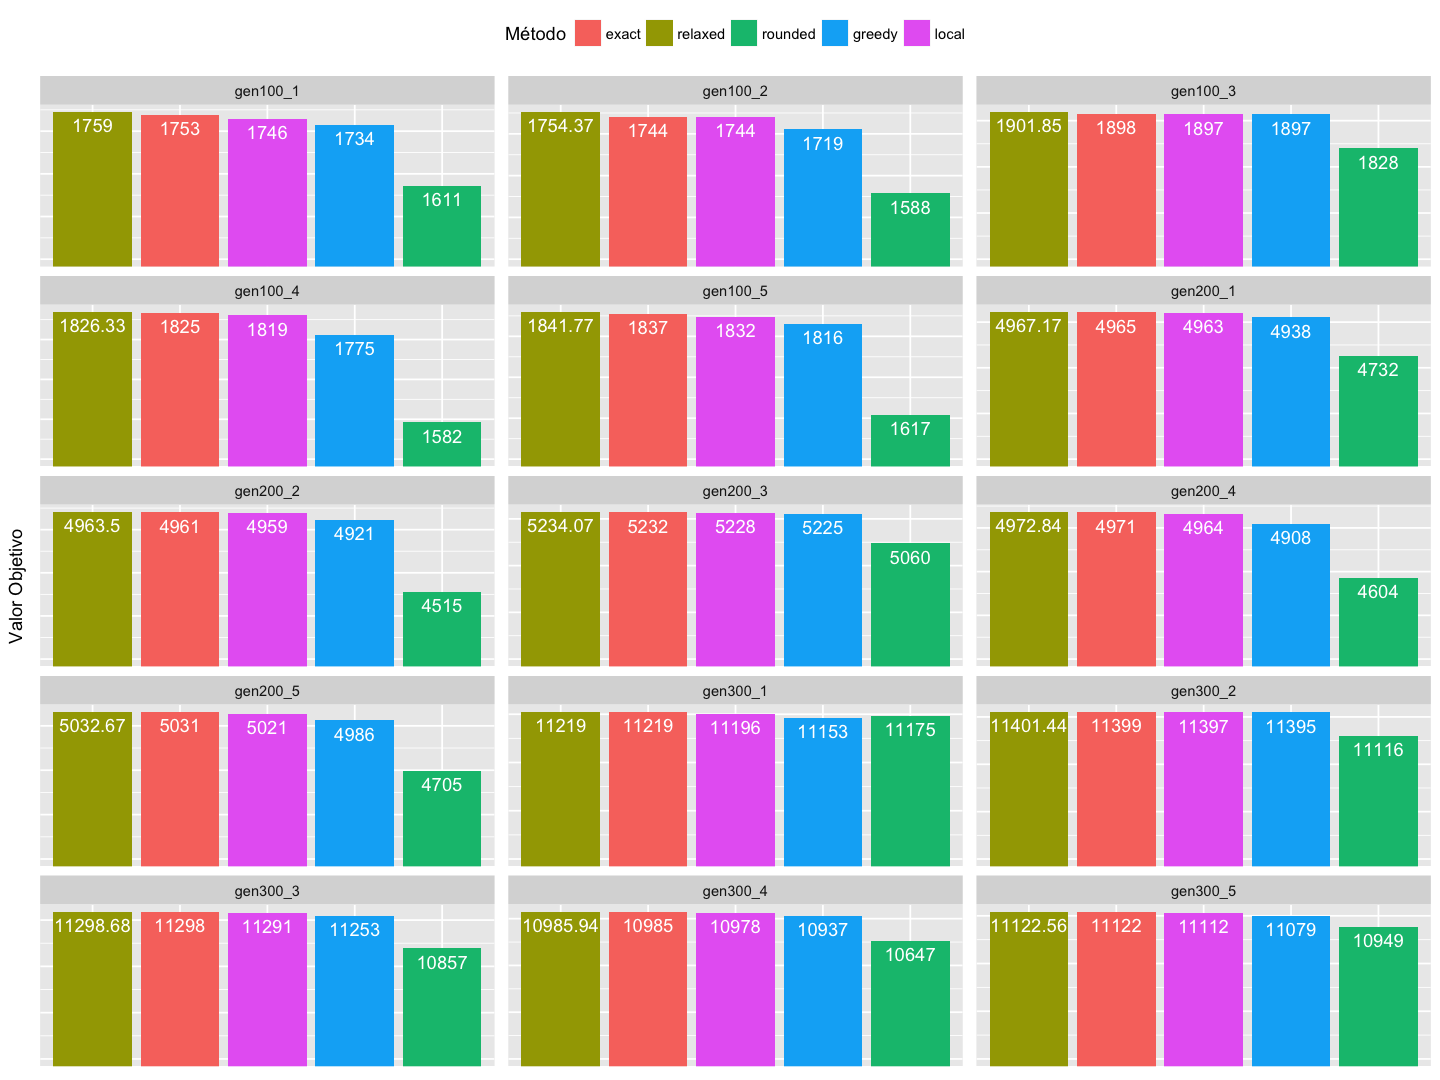

In [17]:
files <- c("gen100_1.txt", "gen100_2.txt", "gen100_3.txt", "gen100_4.txt", "gen100_5.txt",
           "gen200_1.txt", "gen200_2.txt", "gen200_3.txt", "gen200_4.txt", "gen200_5.txt",
           "gen300_1.txt", "gen300_2.txt", "gen300_3.txt", "gen300_4.txt", "gen300_5.txt")

options(repr.plot.height = 9, repr.plot.width = 12)
lapply(files, function(name) {
    ReadSimpleKnapsack(paste0(dataset.folder.simple, name)) %>%
    GenerateSimpleKnapsackSolutions() %>%
    lapply(function(s) {
        s$objval
    }) %>%
    as.data.frame() %>%
    stack()
}) %>% 
set_names(files) %>%
map_df(I, .id = "problem") %>%
mutate(problem = gsub("\\.\\w+$","", problem)) %>%
group_by(problem) %>%
mutate(values = round(values, digits = 2),
       values.rel = values/sum(values)) %>%
ungroup() %>%
ggplot(aes(x = reorder(ind, -values), y = values.rel, fill = ind, label = values)) +
    geom_col() +
    facet_wrap(~problem, ncol = 3, scales="free_y") + 
    ylab("Valor Objetivo") + 
    xlab("Método") + 
    scale_y_continuous(limits=c(0.17, NA),oob = rescale_none) +
    theme(plot.title       = element_text(hjust = 0.5),
          legend.position  = "top",
          axis.title.x     = element_blank(),
          axis.text.x      = element_blank(),
          axis.ticks.x     = element_blank(),
          axis.text.y      = element_blank(),
          axis.ticks.y     = element_blank()) +
    guides(fill = guide_legend(title="Método")) +
    geom_text(position = position_dodge(width = 0.9), 
              vjust = 1.5, color = "white") 


TODO(@garciparedes): Analyze results

### Mochila Múltiple

#### Descripción

El problema de la mochila múltiple consiste en una generalización respecto del descrito en la sección anterior. Este se define de la misma manera, y con las mismas restricciones pero al que además se le añade otro conjunto de características. Estas son las que permiten modelar varios contenedores a en un mismo problema, de tal manera que no haya productos repetidos en cada contenedor. Para ello, se amplia el vector de variables de decisión $X$ a la idea de matriz de $m$ filas donde cada fila representa un contenedor, y $n$ columnas donde cada columna representa un producto. Para que no surja el problema de repetición de productos en distintas mochilas, es necesario restringir que cada producto tan solo pueda estar en una única mochila a la vez.

#### Modelo

El modelo matemático para estudiar este problema se define a continuación (tal y como se puede apreciar, este es una generalización del problema de la mochila simple):

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Maximizar} & \displaystyle \sum\limits_{i=1}^{m}\sum\limits_{j=1}^{n} p_{j} \cdot x_{ij} \\
      \text{sujeto a}  & \sum\limits_{j=1}^{n} w_{j} \cdot x_{ij} \leq c, & \forall i \in \{1,...,m\} \\
                       & \sum\limits_{i=1}^{m} x_{ij} \leq 1, & \forall j \in \{1,...,n\} \\
                       & x_{ij} \in \{0, 1\}, 	& \forall i \in \{1,...,m\}, \forall j \in \{1,...,n\}
    \end{array}
\end{equation}

Dicha modelización se han codificado en el lenguaje *R* a partir de la función `KnapsackMultipleExact()`, que se define a continuación. Sin embargo, debido al elevado coste computacional necesario para la resolución de problemas de cierto tamaño con ella, en los problemas de ejemplo, tan solo se ha utilizado junto con la relajación lineal, debido a que el tiempo necesario para encontrar la solución era impracticable.

In [18]:
KnapsackMultipleExact <- function(p, m, types = "B", max = TRUE, ...) {
    conditions <- matrix(rep(0,(m + p$n) * p$n * m), 
                         nrow = m + p$n, ncol = p$n * m, byrow = TRUE)
    
    for(i in 1:m) {
        conditions[i, (i - 1) * p$n + 1:p$n] <- p$weight
    }
    for(i in (m + 1):(p$n + m)) {
        conditions[i, seq(i-m, p$n*m, by = p$n)] <- 1
    }

    Solve(rep(p$value, m), conditions, 
          c(rep("<=", m + p$n)),
          c(rep(p$capacity, m), rep(1, p$n)),
                 types = types, max = max, ...)
}

#### Heurísticas

Para tratar de paliar la problemática del coste computacional que se da en las soluciones exactas, como la que ha surgido en este caso, la literatura ha propuesto distintas heurísticas que permiten encontrar soluciones razonables con un coste computacional drásticamente menor. Es por ello que las siguientes subsecciones se basan en la explicación de dichas técnicas. Tal y como se irá viendo, estas son una generalización de las descritas para el caso del problema de la mochila simple. Tal es así que en muchos casos utilizaremos estas funciones para resolver el subproblema de cada contenedor.

##### Redondeo

El método de redondeo se basa en la búsqueda de una solución inicial a partir de la relajación lineal aplicada al modelo descrito anteriormente (Esto es eliminando la restricción de que la solución tome valores binarios permitiendo cualquier valor en el intervalo $[0, 1]$) para después redondear inferiormente la solución, con lo que se llega a una solución entera. La razón por la cual se escoge el método de redondeo inferior es para que la solución obtenida siga teniendo garantías de factibilidad. Es decir, que no se seleccionen más productos de los que realmente caben en el contenedor.

A continuación se muestra la implementación del método de redondeo en la función `KnapsackMultipleRounding()`:

In [19]:
KnapsackMultipleRounding <- function(p, m, initial.solution = KnapsackMultipleExact(p, m, types = "C", ...), 
                                     RoundingFunction = trunc, ...) {    
    sol <- list()
    sol$solution = matrix(RoundingFunction(initial.solution$solution), nrow = m, byrow = TRUE)    
    sol$objval   = sum(t(sol$solution) * p$value)
    sol$slack    = p$capacity - colSums(t(sol$solution) * p$weight)
    return(sol)
}

##### Greedy

En este caso, el procedimiento *greedy* se basa en la resolución de cada subproblema  (entendiendo por subproblema la asignación de productos a cada contenedor) por el método del problema de la mochila simple, pero eliminando los productos ya asignados a otros contenedores. Esto se ha llevado a cabo apoyandonos en la función definida al principio para generar subproblemas y llamada `SimpleKnapsackSubSet()`. El procedimiento *greedy* completo se ha implementado en la función `KnapsackMultipleGreedy()`, que se define a continuación:

In [20]:
KnapsackMultipleGreedy <- function(p, m, ...) {
    sol <- list(solution = matrix(rep(0, p$n * m), nrow = m), 
                objval = 0, slack = rep(p$capacity, m))

    for(i in 1:m) {
        p.i <- SimpleKnapsackSubSet(p, colSums(sol$solution) == 0)
        if(!is.null(p.i)) {
            s.i <- KnapsackSimpleGreedy(p.i, ...)
            sol$solution[i, colSums(sol$solution) == 0] <- s.i$solution
            sol$objval <- sol$objval + s.i$objval
            sol$slack[i] <- s.i$slack
        }
        
    }
    
    return(sol)
}

##### Búsqueda Local

El método heurístico de búsqueda local para el problema de la mochila múltiple sigue la misma idea que ocurria con la solución *greedy* ya que se ha realizado una adaptación de la solución para la mochila simple. En este caso, se ha utilizado la misma función (`KnapsackSimpleLocalSearchBest()`)para la búsqueda del mejor intercambio. Este método permite el "movimiento" de productos entre distintos contenedores en cierto sentido. Puede darse el caso en que un producto inicialmente seleccionado en la solución inicial, sea eliminado de un contenedor al añadir otro que maximiza la función de beneficio, para posteriormente volver a ser añadido en otro contenedor donde maximiza la función de beneficio.

La implementación de la heurístca de búsqueda local se ha llevado a cabo a partir de la función `KnapsackMultipleLocalSearch()`, que tal y como vemos, se define a continuación:

In [21]:
KnapsackMultipleLocalSearch <- function(p, m, initial.solution = KnapsackMultipleGreedy(p, m, ...), ...) {
    sol <- initial.solution
    for(i in 1:m) {
        idx0 <- which(colSums(sol$solution) == 0)
        idx1 <- which(sol$solution[i, ] == 1)
    
        best <- KnapsackSimpleLocalSearchBest(p, sol$slack[i], idx0, idx1)
        while (best$v > 0) {
            sol$solution[i, best$i] <- 1
            sol$solution[i, best$j] <- 0
            sol$slack[i] <- sol$slack[i] + p$weight[best$j] - p$weight[best$i]
            sol$objval <- sol$objval + best$v

            idx0 <- c(idx0[idx0 != best$i], best$j)
            idx1 <- c(idx1[idx1 != best$j], best$i)

            best <- KnapsackSimpleLocalSearchBest(p, sol$slack[i], idx0, idx1)
        }
    }
    
    return(sol)
}

### Ejemplos

A continuación se han incluido distintos ejemplos para comprobar la validez de los métodos heurísticos frente a las soluciones exactas. Para cada problema se ha calculado los siguiente:
  * Solución de la *relajación lineal*: $z_L$
  * Solución del procedimiento *exacto*: $z_E$
  * Solución por el método de redondeo: $z_R$
  * Solución por el método *greedy*: $z_G$
  * Solución por el método de *búsqueda local*: $z_{LS}$
  
Estas soluciones se relacionan entre si de cierta manera. En cuanto a las soluciones basadas en los métodos exactos, se puede asegurar que la solución exacta $z_E$ siempre se encontrará entre la solución de la rejación lineal $z_L$ (cota superior) y la del método de redondeo $z_R$ (cota inferior). Comprobaremos que dicha propiedad se cumple en los resultados obtenidos. De manera más matemática esto es:

$$z_R \leq z_E \leq z_L$$


Otra propiedad a tener en cuenta es que cuando la solución de la relajación lineal es entera y esta pertenecerá a la región factible del espacio de soluciones del problema, por lo que coincide con la solución exacta. Además, dado que esta ya es entera, también condicidirá con la de redondeo.

También hay otra propiedad interesante que se cumple, en este caso relacionada con el método de búsqueda local. Este siempre será mayor o igual a la solución inicial en la que se base. Dado que en este caso hemos utilizado la solución *greedy* como solución inicial, esta propiedad se cumplirá entre ellas. Por tanto, en este caso se cumplirá la siguiente desigualdad:

$$z_G \leq z_{LS}$$

En este caso, se han resuelto los problemas suponiendo la disponibilidad de $m = 3$ contenedores. Para tratar de automatizar la ejecución de los ejemplos, se ha creado la función `GenerateMultipleKnapsackSolutions()`, que a partir de un problema, genera las soluciones por todos los métodos propuestos, para después poder evaluarlas en conjunto.

In [22]:
m <- 3

In [23]:
GenerateMultipleKnapsackSolutions <- function(p, m, ...) {
    sol <- list()
    
    # s <- KnapsackMultipleExact(p, m, ...)
    # sol$exact <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
    #                   objval   = s$optimum,
    #                   slack    = p$capacity - s$auxiliary$primal[1])
    
    s.relaxed <- KnapsackMultipleExact(p, m, types = "C", ...)
    sol$relaxed <- list(solution = matrix(s.relaxed$solution, ncol = p$n, byrow = TRUE),
                        objval   = s.relaxed$optimum,
                        slack    = matrix(rep(p$capacity, m) - s.relaxed$auxiliary$primal[m], 
                                          ncol = m, byrow =TRUE))

    s.rounded <- KnapsackMultipleRounding(p, m, initial.solution = s.relaxed, ...)
    sol$rounded <- list(solution = s.rounded$solution,
                        objval   = s.rounded$objval,
                        slack    = matrix(s.rounded$slack, ncol = m, byrow = TRUE))

    s.greedy <- KnapsackMultipleGreedy(p, m, ...)
    sol$greedy <- list(solution = s.greedy$solution,
                       objval   = s.greedy$objval,
                       slack    = matrix(s.greedy$slack, ncol = m, byrow = TRUE))

    s.local <- KnapsackMultipleLocalSearch(p, m, initial.solution = s.greedy, ...)
    sol$local <- list(solution = s.local$solution, ncol = p$n,
                      objval   = s.local$objval,
                      slack    = matrix(s.local$slack, ncol = m, byrow = TRUE))
    
    return(sol)
}

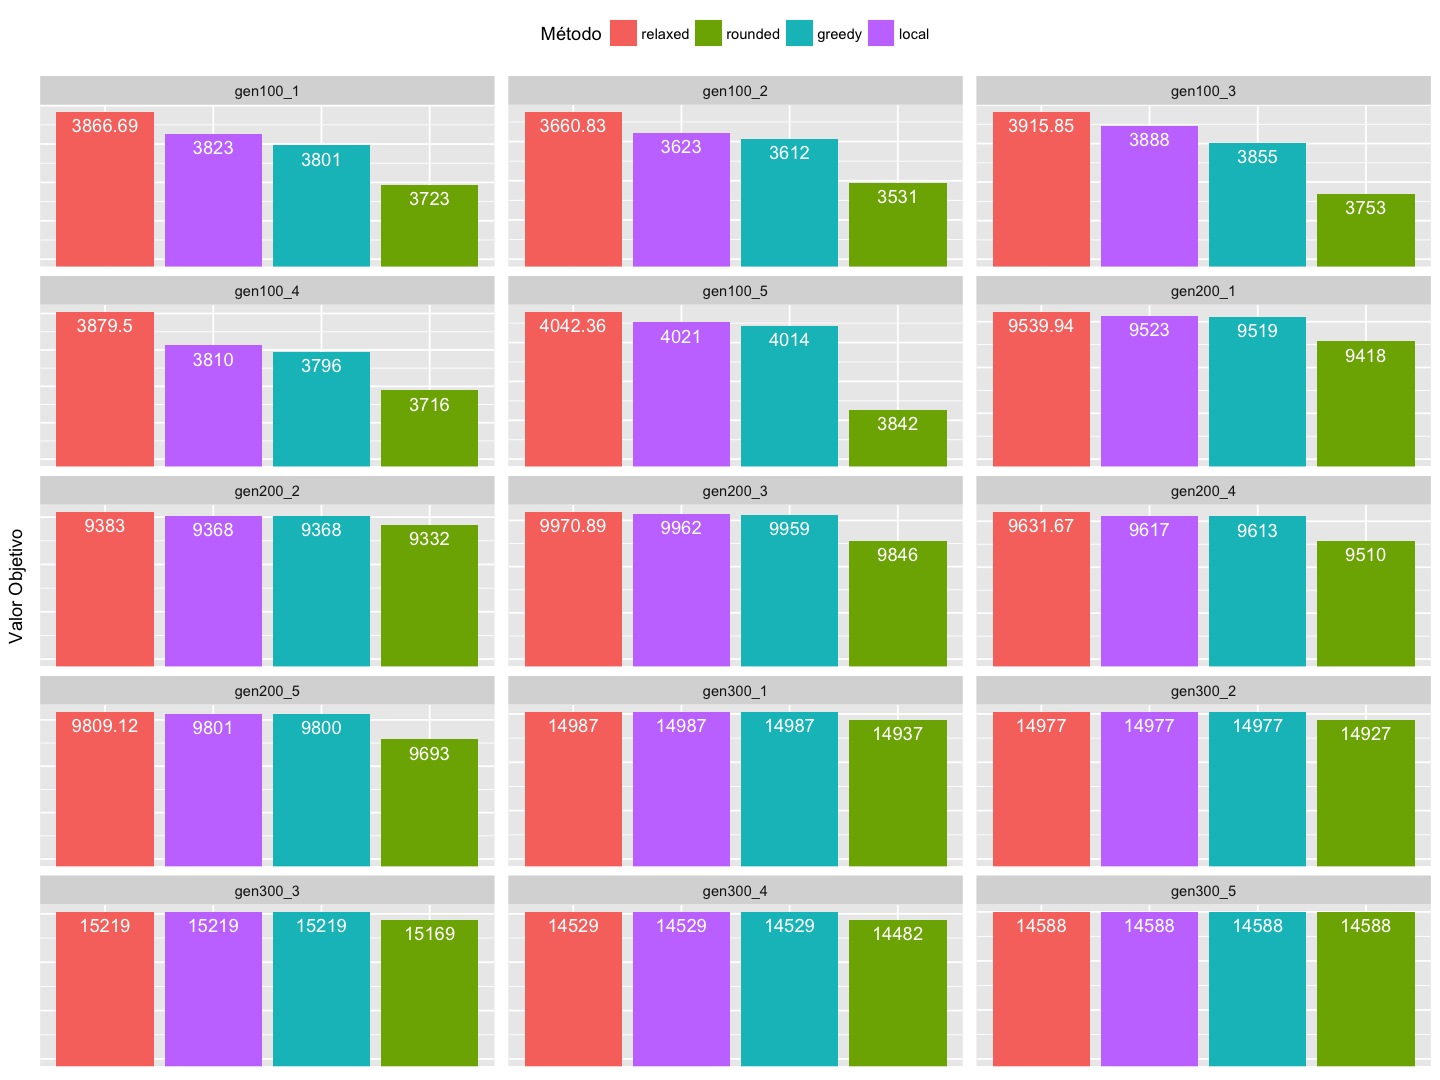

In [24]:
files <- c("gen100_1.txt", "gen100_2.txt", "gen100_3.txt", "gen100_4.txt", "gen100_5.txt",
           "gen200_1.txt", "gen200_2.txt", "gen200_3.txt", "gen200_4.txt", "gen200_5.txt",
           "gen300_1.txt", "gen300_2.txt", "gen300_3.txt", "gen300_4.txt", "gen300_5.txt")

options(repr.plot.height = 9, repr.plot.width = 12)
lapply(files, function(name) {
    ReadSimpleKnapsack(paste0(dataset.folder.simple, name)) %>%
    GenerateMultipleKnapsackSolutions(m) %>%
    lapply(function(s) {
        s$objval
    }) %>%
    as.data.frame() %>%
    stack()
}) %>% 
set_names(files) %>%
map_df(I, .id = "problem") %>%
mutate(problem = gsub("\\.\\w+$","", problem)) %>%
group_by(problem) %>%
mutate(values = round(values, digits = 2),
       values.rel = values/sum(values)) %>%
ungroup() %>%
ggplot(aes(x = reorder(ind, -values), y = values.rel, fill = ind, label = values)) +
    geom_col() +
    facet_wrap(~problem, ncol = 3, scales="free_y") + 
    ylab("Valor Objetivo") + 
    xlab("Método") + 
    scale_y_continuous(limits=c(0.235, NA),oob = rescale_none) +
    theme(plot.title       = element_text(hjust = 0.5),
          legend.position  = "top",
          axis.title.x     = element_blank(),
          axis.text.x      = element_blank(),
          axis.ticks.x     = element_blank(),
          axis.text.y      = element_blank(),
          axis.ticks.y     = element_blank()
         ) +
    guides(fill = guide_legend(title="Método")) +
    geom_text(position = position_dodge(width = 0.9), 
              vjust = 1.5, color = "white") 


TODO(@garciparedes): Analyze results

### Mochila Multidimensional

#### Descripción

El *problema de la mochila multidimensional* se presenta como otra generalización del problema de la mochila simple, pero en este caso en el sentido de que un producto puede ser visto desde distintos puntos de vista (varias dimensiones). Por tanto, ahora nuestro problema es una generalización del anterior, solo que en este caso la capacidad del contenedor estará compuesta por $m$ dimensiones, así como el peso (o tamaño) de cada producto. A primera vista, el problema puede parecer totalmente equivalente, sin embargo, no lo es ya que ahora resulta más complicado elegir qué producto introducir o no en el contenedor para maximizar la ganancia aprovechando el espacio (Esto se explicará en detalle al hablar de los distintos criterios de selección en el método *greedy*)

#### Modelo

A continuación se define el modelo matemático de programación lineal para el problema de la mochila multidimensional, el cual se caracteriza por tener $m$ restricciones de capacidad en lugar de una, dado que nuestro problema ahora será $m$-dimensional.

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{j=1}^{n} p_{j} \cdot x_{j} \\
      \text{sujeto a}  & \sum\limits_{j=1}^{n} a_{ij} \cdot x_{j} \leq b_{i}, & \forall i \in \{1,...,m\} \\
                       & x_{j} \in \{0, 1\}, & \forall j \in \{1,...,n\}
    \end{array}
\end{equation}

La codificación en el lengua *R* de la modelización descrita superiormente se ha llevado a cabo en la función `KnapsackMultidimensionalExact()` la cual se muestra a continuación:

In [25]:
KnapsackMultidimensionalExact <- function(p, types = "B", max = TRUE, ...) {
    Solve(p$value, rbind(p$weight, diag(p$n)), rep("<=", length(p$capacity) + p$n), 
          c(p$capacity, rep(1, p$n)), types = types, max = max, ...)
}

#### Heurísticas

Para el problema de la mochila multidimensional se han desarrollado distintas heurísticas que permiten llegar a soluciones razonables a partir costes computacionales mucho menores. Estas son muy similares a las heuristicas de las que se habló en para el caso del problema de la mochila simple. Sin embargo, en este caso es de vital importancia el criterio de selección para elegir qué objeto introducir en la mochila en cada caso como veremos a continuación. Las heurísticas que se van a analizar son las siguientes: *redondeo*, método *greedy* y método de mejora basado en *búsqueda local*.

##### Redondeo

La heurística de redondeo para el problema de la mochila multidimensional es completamente equivalente a la de la mochila simple. Consiste en obtener una solución a partir de la relajación lineal para posteriormente llegar a una solución factible redondeando inferiormente las variables relajadas, de tal manera que se garantice estar sobre la región de aceptación del problema

Dicha implementación se ha llevado a cabo a partir de la función `KnapsackMultidimensionalRounding()`. La cual se muestra a continuación:

In [26]:
KnapsackMultidimensionalRounding <- function(p, m, initial.solution = KnapsackMultidimensionalExact(p, types = "C", ...), 
                                     RoundingFunction = floor, ...) {    
    sol <- list()
    sol$solution = RoundingFunction(initial.solution$solution)
    sol$objval   = sum(sol$solution * p$value)
    sol$slack    = p$capacity - colSums(sol$solution * t(p$weight))
    return(sol)
}

##### Greedy

Tal y como se ha indicado anteriormente, el método greedy en este caso es equivalente al utilizado en otros casos (procedimiento iterativo que selecciona la mejor solución posible siguiendo algún criterio en cada ciclo hasta quedarse sin alternativas posibles). Sin embargo, en este caso es de vital importancia la elección de un criterio adecuado, ya que el problema es multidimensional. Esto dificulta el problema dado que el criterio escogido debe proporcionar resultados aceptables teniendo en cuenta precisamente lo que ocurre en todas las dimensiones. Es por ello que existen distintas alternativas (donde $g_j$ representa la valoración del producto $j$-ésimo): 
  * Basado en valoracion relativa: $$g_j = \frac{p_j}{\sum_{i=1}^m \mu_i \cdot a_{ij}}$$
  * Basado en escasez: $$g_j = \frac{p_j}{\sum_{i=1}^m \frac{a_{ij}}{b_i}}$$
  * Basado en relajación lineal: $$g_j = x^{relax}_j$$
  * Basado en holguras: $$g_j = holgura(x^{relax}_{j})$$
  
Estos criterios tratan de cuantificar de manera razonable la selección del producto $j$-ésimo. Cabe destacar el criterio de selección basado en escasez, que debe ser recalculado en cada iteracción del método *greedy* (el resto se mantienen constantes). De manera empírica se ha comprobado que los mejores resultados se obtienen valorando los productos a partir de las soluciones del problema relajado, tal y como veremos a continuación, aunque el coste computacional es alto.

La función `MultidimensionalCriterionRelative()` implementa el criterio de selección basado en valoraciones relativas. Esta se implementa a continuación:

In [27]:
MultidimensionalCriterionRelative <- function(g, p, sol, dim.weight = rep(1, p$m)) {
    if (!is.null(g)) {
        g
    } else {
        p$value / colSums(dim.weight * p$weight)
    }
}

La función `MultidimensionalCriterionShortage()` implementa el criterio de selección basado en escasez. Esta se implementa a continuación:

In [28]:
MultidimensionalCriterionShortage <- function(g, p, sol, dim.weight = rep(1, p$m)) {
    MultidimensionalCriterionRelative(g, p, sol, dim.weight = 1  / sol$slack)
}

La función `MultidimensionalCriterionRelaxed()` implementa el criterio de selección basado en soluciones de la relajación lineal. Esta se implementa a continuación:

In [29]:
MultidimensionalCriterionRelaxed <- function(g, p, sol) {
    if (!is.null(g)) {
        g
    } else {
        KnapsackMultidimensionalExact(p, types = "C" )$solution
    }
}

La función `MultidimensionalCriterionSlack()` implementa el criterio de selección basado en holguras de la relajación lineal. Esta se implementa a continuación:

In [30]:
MultidimensionalCriterionSlack <- function(g, p, sol) {
    if (!is.null(g)) {
        g
    } else {
        MultidimensionalCriterionRelative(g, p, sol, 
            dim.weight = KnapsackMultidimensionalExact(p, types = "C" )$auxiliary$primal[1:p$m]
        )
    }
}

La función `KnapsackMultidimensionalGreedy()` implementa el método *greedy* para la resolución del problema de la mochila multidimensional. Dicha implementación se muestra a continuación:

In [31]:
KnapsackMultidimensionalGreedy <- function(p, Criterion = MultidimensionalCriterionRelative, ...) {
        sol <- list(solution = rep(0, p$n), 
                objval = 0, slack = p$capacity)
    
    g <- Criterion(NULL, p, sol)
    i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]
    
    while (!is.na(i) && all(sol$slack - p$weight[,i] > 0)) {
        sol$solution[i] <- 1
        sol$objval <- sol$objval + p$value[i]
        sol$slack <- sol$slack - p$weight[,i]
        g <- Criterion(g, p, sol)
        if (any(sol$solution == 0)) {
            i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]
        } else {
            i <- NA
        }
    }
    return(sol)
}

##### Búsqueda Local

Al igual que para los problemas de la mochila estudiados anteriormente, para el caso multidimensional también se puede diseñar una heurística de mejora basada en búsqueda local. Esta requiere de una solución inicial que después trata de mejorar mediante combinatoria. Este método, al igual que en los anteriores casos, busca el mejor intercambio posible en cada iteración, hasta que ya no se pueda realizar ninguno más.

La función `KnapsackMultidimensionalLocalSearchBest()` implementa la búsqueda de dicho cambio, la cual se muestra a continuación:

In [32]:
KnapsackMultidimensionalLocalSearchBest <- function(p, slack, idx0, idx1) {
    best = list(v = 0, i = 0, j = 0)
    for (i in idx0) {
        for (j in idx1) {
            if (all(slack + p$weight[, j] - p$weight[, i] > 0)) {
                v.temp <- p$value[i] - p$value[j]
                if (best$v < v.temp) {
                    best$v <- v.temp
                    best$i <- i
                    best$j <- j
                }   
            }
        }
    }
    return(best)
}

La función `KnapsackMultidimensionalLocalSearch()` implementa el método de búsqueda local, partiendo por defecto de una solución *greedy* que trata de mejorar mediante intercambios hasta que ya no se puede mejorar más. La implementación en *R* se muestra a continuación:

In [33]:
KnapsackMultidimensionalLocalSearch <- function(p, initial.solution = KnapsackMultidimensionalGreedy(p, ...), ...) {
    sol <- initial.solution
    
    idx0 <- which(sol$solution == 0)
    idx1 <- which(sol$solution == 1)
    
    best <- KnapsackMultidimensionalLocalSearchBest(p, sol$slack, idx0, idx1)
    while (best$v > 0) {
        sol$solution[best$i] <- 1
        sol$solution[best$j] <- 0
        sol$slack <- sol$slack + p$weight[, best$j] - p$weight[, best$i]
        sol$objval <- sol$objval + best$v
        
        idx0 <- c(idx0[idx0 != best$i], best$j)
        idx1 <- c(idx1[idx1 != best$j], best$i)
        
        best <- KnapsackMultidimensionalLocalSearchBest(p, sol$slack, idx0, idx1)
    }
    return(sol)    
}

### Ejemplos

A continuación se han incluido distintos ejemplos para comprobar la validez de los métodos heurísticos frente a las soluciones exactas. Para cada problema se ha calculado los siguiente:
  * Solución de la *relajación lineal*: $z_L$
  * Solución del procedimiento *exacto*: $z_E$
  * Solución por el método de redondeo: $z_R$
  * Solución por el método *greedy*: $z_G$
  * Solución por el método de *búsqueda local*: $z_{LS}$
  
Estas soluciones se relacionan entre si de cierta manera. En cuanto a las soluciones basadas en los métodos exactos, se puede asegurar que la solución exacta $z_E$ siempre se encontrará entre la solución de la rejación lineal $z_L$ (cota superior) y la del método de redondeo $z_R$ (cota inferior). Comprobaremos que dicha propiedad se cumple en los resultados obtenidos. De manera más matemática esto es:

$$z_R \leq z_E \leq z_L$$


Otra propiedad a tener en cuenta es que cuando la solución de la relajación lineal es entera y esta pertenecerá a la región factible del espacio de soluciones del problema, por lo que coincide con la solución exacta. Además, dado que esta ya es entera, también condicidirá con la de redondeo.

También hay otra propiedad interesante que se cumple, en este caso relacionada con el método de búsqueda local. Este siempre será mayor o igual a la solución inicial en la que se base. Dado que en este caso hemos utilizado la solución *greedy* como solución inicial, esta propiedad se cumplirá entre ellas. Por tanto, en este caso se cumplirá la siguiente desigualdad:

$$z_G \leq z_{LS}$$

En este caso, se han probado todos los criterios de selección propuestos para el método *greedy*, junto con sus correspondientes mejoras basadas en búsqueda local. En cada caso concreto se discutirán las diferencias de resultados.

Para tratar de automatizar la ejecución de los ejemplos, se ha creado la función `GenerateMultidimensionalKnapsackSolutions()`, que a partir de un problema, genera las soluciones por todos los métodos propuestos, para después poder evaluarlas en conjunto.

In [34]:
GenerateMultidimensionalKnapsackSolutions <- function(p, ...) {
    sol <- list()
    
    s.exact <- KnapsackMultidimensionalExact(p, ...)
    sol$exact <- list(solution = matrix(s.exact$solution, ncol = p$n, byrow = TRUE),
                      objval   = s.exact$optimum,
                      slack    = matrix(p$capacity - colSums(s.exact$solution * t(p$weight)), 
                                        ncol = p$m, byrow = TRUE))

    s.relaxed <- KnapsackMultidimensionalExact(p, types = "C", ...)
    sol$relaxed <- list(solution = matrix(s.relaxed$solution, ncol = p$n, byrow = TRUE),
                        objval   = s.relaxed$optimum,
                        slack    = matrix(p$capacity - colSums(s.relaxed$solution * t(p$weight)), 
                                          ncol = p$m, byrow = TRUE))

    s.rounded <- KnapsackMultidimensionalRounding(p, initial.solution = s.relaxed, ...)
    sol$rounded <- list(solution = matrix(s.rounded$solution, ncol = p$n, byrow = TRUE),
                        objval   = s.rounded$objval,
                        slack    = matrix(s.rounded$slack, ncol = p$m, byrow = TRUE))

    
    s.greedy.relative <- KnapsackMultidimensionalGreedy(p, Criterion = MultidimensionalCriterionRelative, ...)
    sol$greedy.relative <- list(solution = matrix(s.greedy.relative$solution, ncol = p$n, byrow = TRUE),
                                objval   = s.greedy.relative$objval,
                                slack    = matrix(s.greedy.relative$slack, ncol = p$m, byrow = TRUE))

    s.local.relative <- KnapsackMultidimensionalLocalSearch(p, initial.solution = s.greedy.relative, ...)
    sol$local.relative <- list(solution = matrix(s.local.relative$solution, ncol = p$n, byrow = TRUE),
                               objval   = s.local.relative$objval, 
                               slack    = matrix(s.local.relative$slack, ncol = p$m, byrow = TRUE))
    
    
    s.greedy.short <- KnapsackMultidimensionalGreedy(p, Criterion = MultidimensionalCriterionShortage, ...)
    sol$greedy.short <- list(solution = matrix(s.greedy.short$solution, ncol = p$n, byrow = TRUE),
                       objval   = s.greedy.short$objval,
                       slack    = matrix(s.greedy.short$slack, ncol = p$m, byrow = TRUE))

    s.local.short <- KnapsackMultidimensionalLocalSearch(p, initial.solution = s.greedy.short, ...)
    sol$local.short <- list(solution = matrix(s.local.short$solution, ncol = p$n, byrow = TRUE),
                            objval   = s.local.short$objval, 
                            slack    = matrix(s.local.short$slack, ncol = p$m, byrow = TRUE))
    
    
    s.greedy.relaxed <- KnapsackMultidimensionalGreedy(p, Criterion = MultidimensionalCriterionRelaxed, ...)
    sol$greedy.relaxed <- list(solution = matrix(s.greedy.relaxed$solution, ncol = p$n, byrow = TRUE),
                       objval   = s.greedy.relaxed$objval,
                       slack    = matrix(s.greedy.relaxed$slack, ncol = p$m, byrow = TRUE))

    s.local.relaxed <- KnapsackMultidimensionalLocalSearch(p, initial.solution = s.greedy.relaxed, ...)
    sol$local.relaxed <- list(solution = matrix(s.local.relaxed$solution, ncol = p$n, byrow = TRUE),
                              objval   = s.local.relaxed$objval, 
                              slack    = matrix(s.local.relaxed$slack, ncol = p$m, byrow = TRUE))
    
    
    s.greedy.slack <- KnapsackMultidimensionalGreedy(p, Criterion = MultidimensionalCriterionSlack, ...)
    sol$greedy.slack <- list(solution = matrix(s.greedy.slack$solution, ncol = p$n, byrow = TRUE),
                            objval   = s.greedy.slack$objval,
                            slack    = matrix(s.greedy.slack$slack, ncol = p$m, byrow = TRUE))

    s.local.slack <- KnapsackMultidimensionalLocalSearch(p, initial.solution = s.greedy.slack, ...)
    sol$local.slack <- list(solution = matrix(s.local.slack$solution, ncol = p$n, byrow = TRUE),
                            objval   = s.local.slack$objval, 
                            slack    = matrix(s.local.slack$slack, ncol = p$m, byrow = TRUE))
    
    return(sol)
}

In [35]:
PlotKnapsackSolutions <- function(s) {
    options(repr.plot.height = 4, repr.plot.width = 12)
    lapply(s, function(x) {
        x$objval
    }) %>%
    unlist() %>%
    stack() %>% 
    dplyr::mutate(ind = factor(ind, levels = c("exact", "relaxed", "rounded", "greedy", "local", 
                                               "greedy.relative", "local.relative", "greedy.short", "local.short", 
                                               "greedy.relaxed", "local.relaxed", "greedy.slack", "local.slack"), 
                               labels = list(exact   = "Exacto", relaxed     = "Relajación Lineal", 
                                             rounded = "H. Redondeo", greedy = "H. Greedy",
                                             local   = "H. Búsqueda Local", 
                                             greedy.relative = "H. Greedy C. Relativo", 
                                             local.relative = "H. Búsqueda Local C. Relativo", 
                                             greedy.short = "H. Greedy C. Escasez", 
                                             local.short = "H. Búsqueda Local C. Escasez", 
                                             greedy.relaxed = "H. Greedy C. Relajado", 
                                             local.relaxed = "H. Búsqueda Local C. Relajado", 
                                             greedy.slack = "H. Greedy C. Sombra", 
                                             local.slack = "H. Búsqueda Local C. Sombra"))) %>% {
    ggplot(data = ., aes(x = reorder(ind, -values), y = values, fill = ind, label = round(values, digits = 2))) + 
        scale_y_continuous(limits = range(.$values) + (max(.$values) - min(.$values)) * c(-0.1, 0.1), 
                           oob = rescale_none) +
        geom_col() + 
        ggtitle("Resultados") +
        ylab("Valor Objetivo") + 
        xlab("Método") + 
        theme(plot.title       = element_text(hjust = 0.5),
              legend.position  = "top",
              axis.title.x     = element_blank(),
              axis.text.x      = element_blank(),
              axis.ticks.x     = element_blank()) +
        guides(fill = guide_legend(title="Método", ncol=6, title.position = "top")) +
        geom_text(position = position_dodge(width = 0.9), 
                  vjust = 1.5, color = "white") 
    }    
}

##### mknap1.2

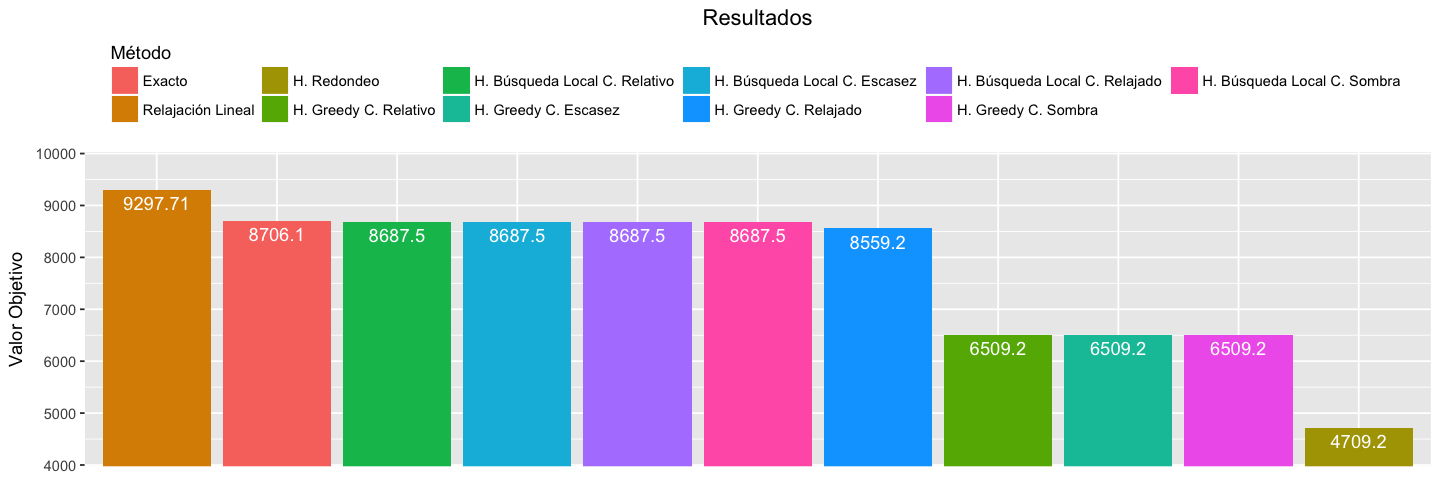

In [36]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_2.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.3

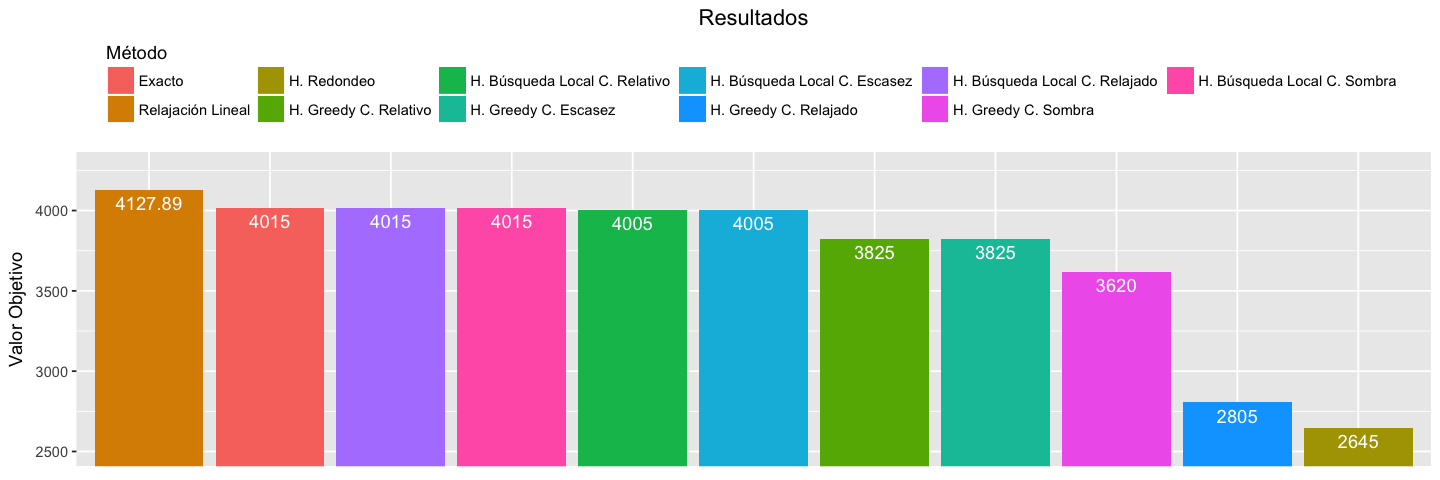

In [37]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_3.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.4

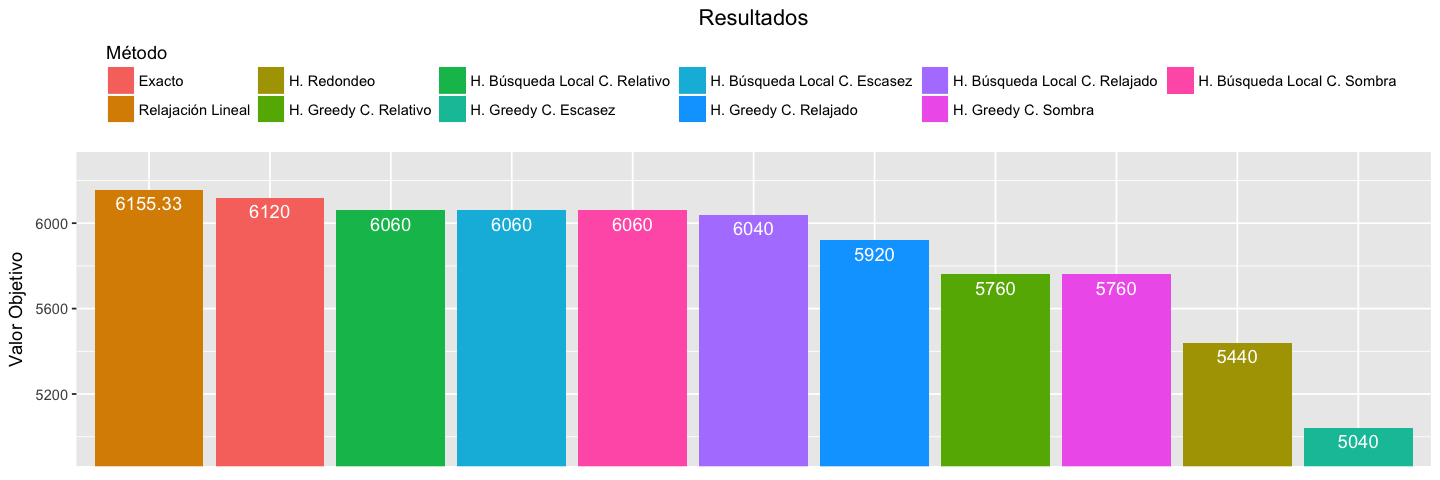

In [38]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_4.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.6

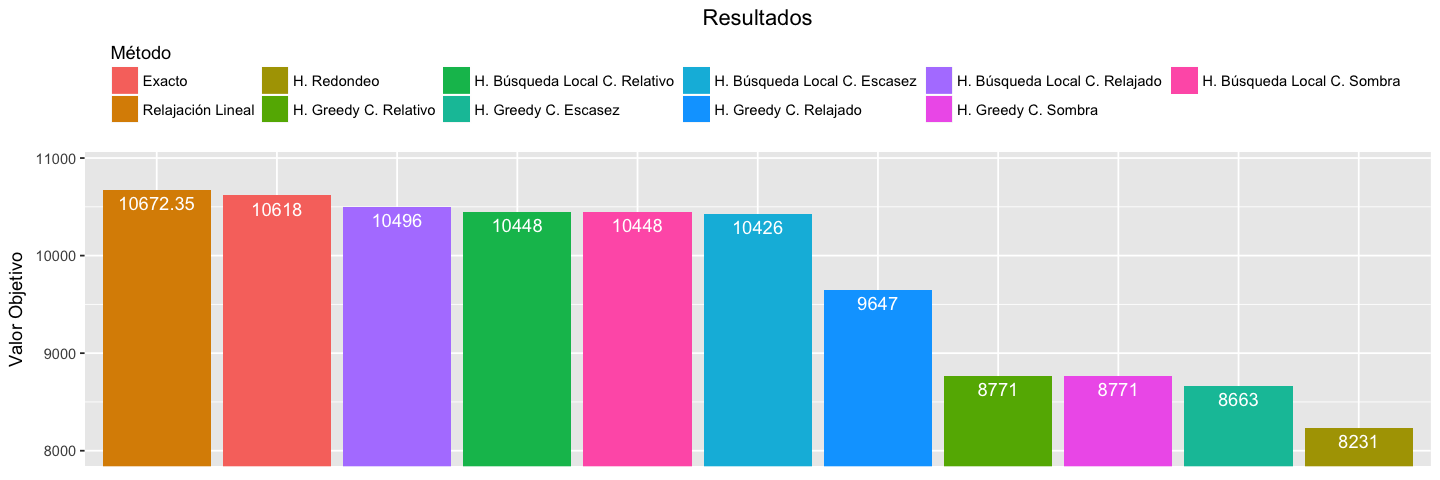

In [39]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_6.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.7

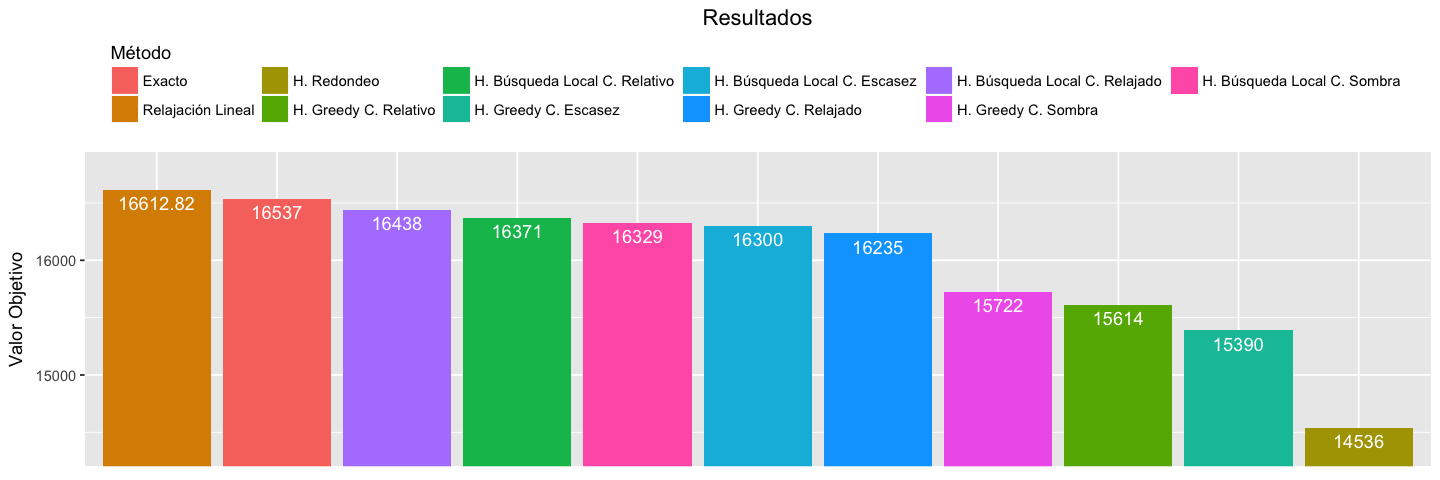

In [40]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_7.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.1

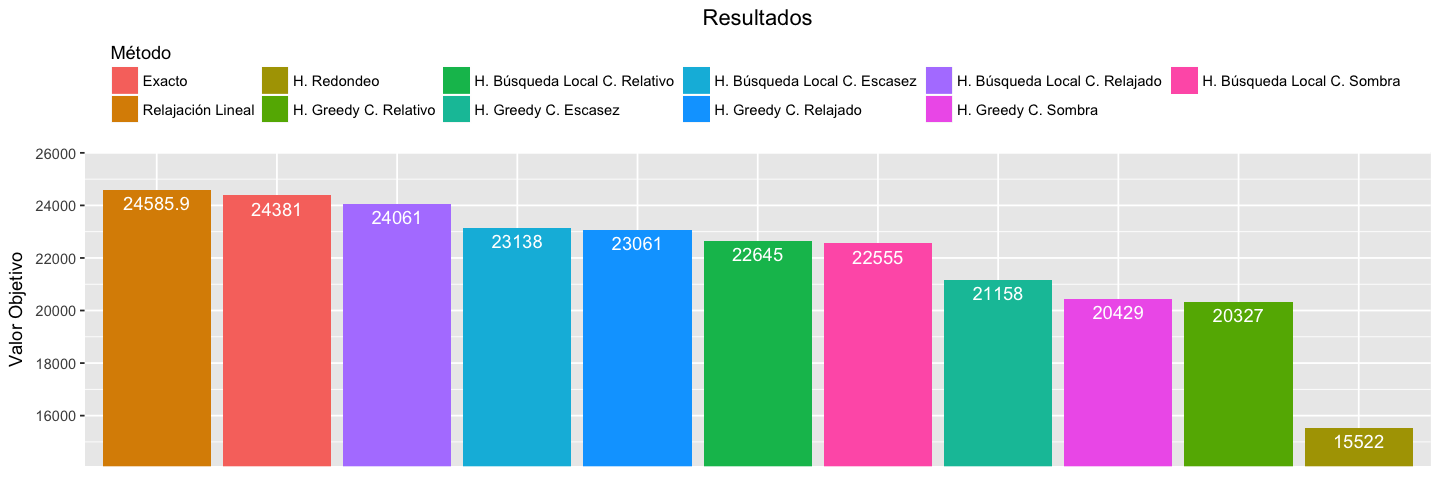

In [41]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_1.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.2

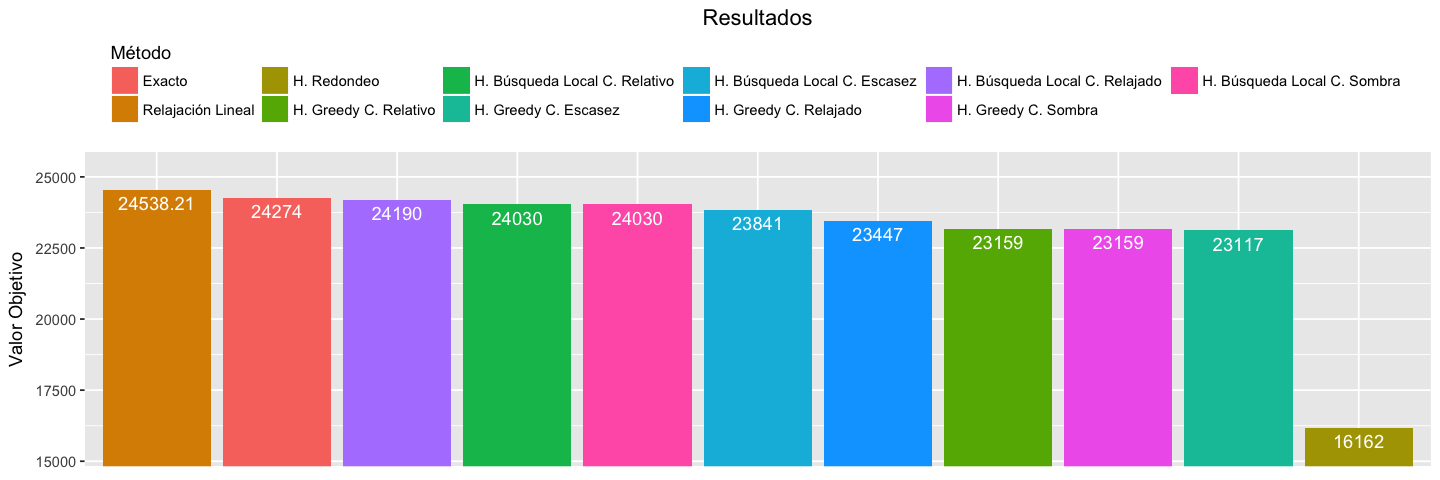

In [42]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_2.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.3

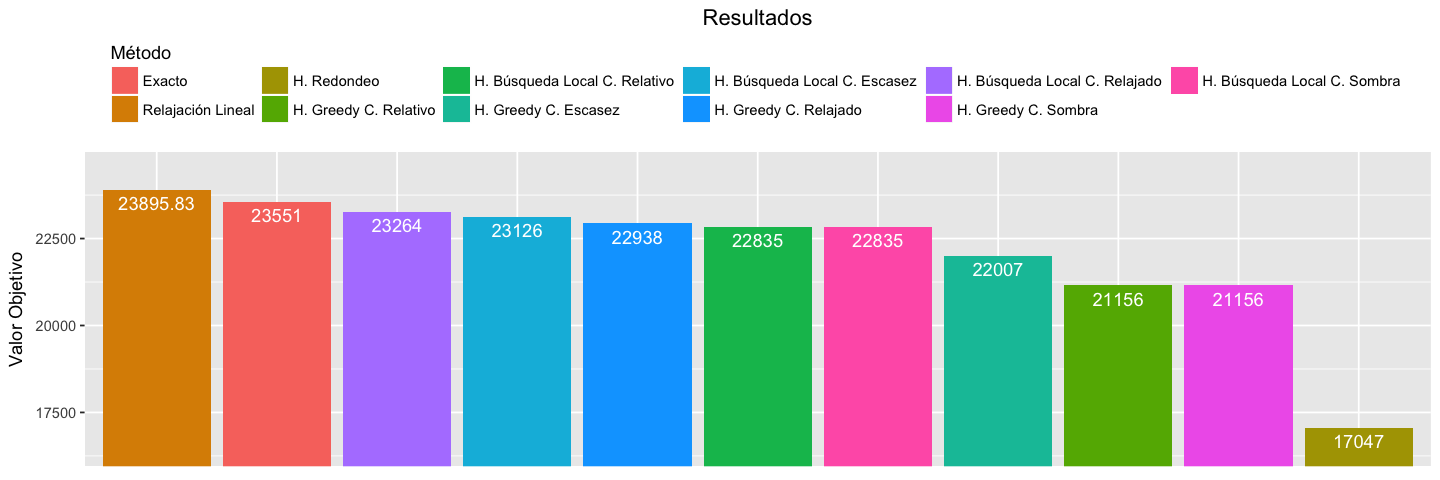

In [43]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_3.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.4

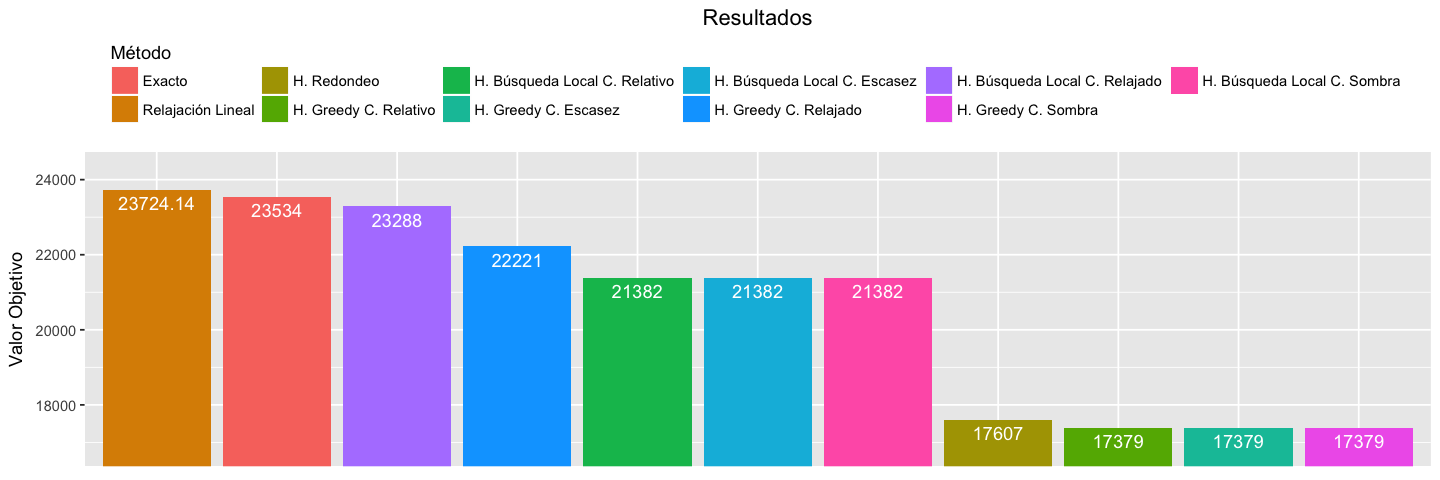

In [44]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_4.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.5

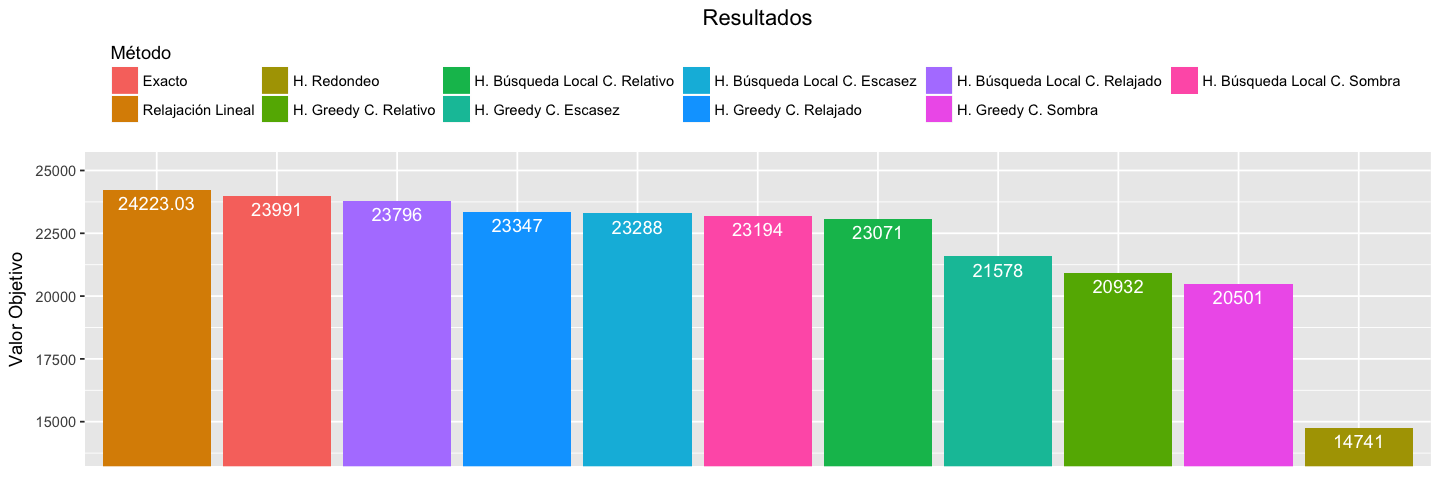

In [45]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_5.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

## Problema de Empaquetamiento

#### Descripción

TODO

### Empaquetamiento Unidimensional

#### Descripción
TODO

#### Modelo
TODO

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{i=1}^{m} c_{i} \cdot y_{i} \\
      \text{sujeto a}  & \sum\limits_{i=1}^{m} x_{ij} = 1, & \forall j \in \{1,...,n\} \\
                       & \sum\limits_{j=1}^{n} a_{j} \cdot x_{ij} \leq q_{i} \cdot y_{i}, & \forall i \in \{1,...,m\} \\
                       & x_{ij} \in \{0, 1\}, & \forall i \in \{1,...,m\}, \forall j \in \{1,...,n\} \\
                       & y_{i} \in \{0, 1\}, & \forall i \in \{1,...,m\} 
    \end{array}
\end{equation}

#### Heurísticas

TODO

##### Primera Disminución del Ajuste

TODO

In [46]:
OneDimBinPackingFFD <- function(p, ...) {
    sol <- list(bins = 1, solution = list(), 
                slack = c(p$capacity))
    idx.sorted <- order( - p$size)
    for(i in idx.sorted) {
        j <- 1
        while(j < sol$bins && sol$slack[j] < p$size[i]) {
            j <- j + 1
        }
        if (sol$bins == j) {
            sol$bins <- sol$bins + 1
            sol$slack <- c(sol$slack, p$capacity)
            sol$solution[[j]] <- c(i)
        } else {
            sol$solution[[j]] <- c(sol$solution[[j]], i)
        }
        sol$slack[j] <- sol$slack[j] - p$size[i]
    }
    if (sol$slack[sol$bins] == p$capacity) {
        sol$slack <- head(sol$slack, -1)
        sol$bins <- sol$bins - 1
    }
    return(sol)
}

### Ejemplos

In [47]:
PlotBinPacking <- function(p, Method = OneDimBinPackingFFD) {
    options(repr.plot.height = 3, repr.plot.width = 9)
    p %>% {
        s <- Method(.)
        lapply(s$solution, function(x) {
        data.frame(id = x, size = .$size[x])
    }) %>% 
    map_df(I, .id = "bin") %>%
    ggplot(aes(x = sprintf("%03d", as.numeric(bin)), 
               y = size, fill = as.character(id))) +
        geom_bar(stat = "sum", show.legend = FALSE)  +
        xlab("Contenedor") +
        ylab("Espacio Ocupado") +
        geom_hline(yintercept  = .$capacity, col = "red") +
        ggtitle(paste0("Problema: ", .$name, "    Contenedores: ", s$bins)) + 
        theme(plot.title       = element_text(hjust = 0.5),
              axis.title.x     = element_blank(),
              axis.text.x      = element_blank(),
              axis.ticks.x     = element_blank(), 
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.background = element_blank())
    }
    
}

##### u120.00

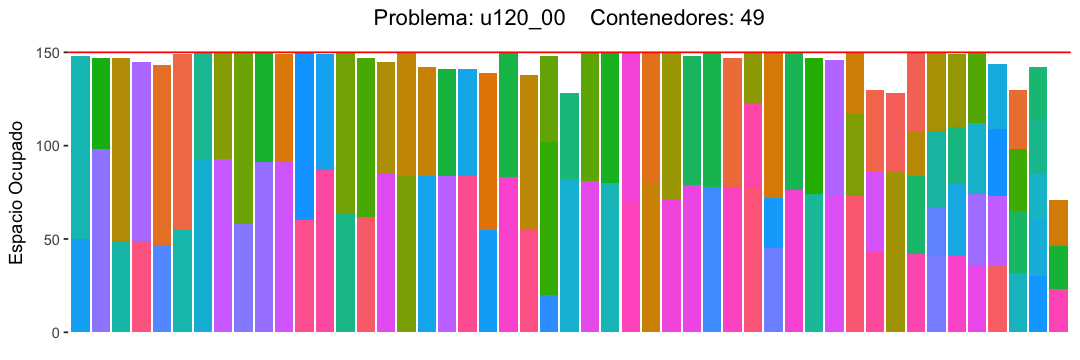

In [48]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u120_00.dat"))  %>%  
PlotBinPacking() 

##### u120.01

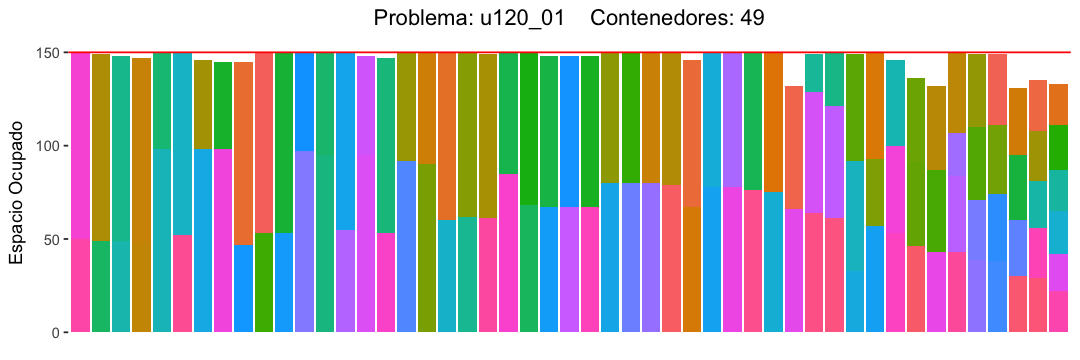

In [49]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u120_01.dat"))  %>%  
PlotBinPacking() 

##### u120.02

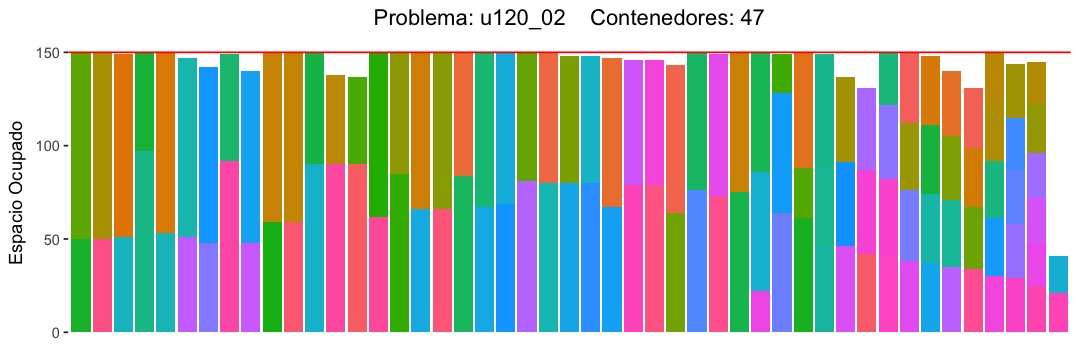

In [50]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u120_02.dat")) %>% 
PlotBinPacking() 

##### u250.00

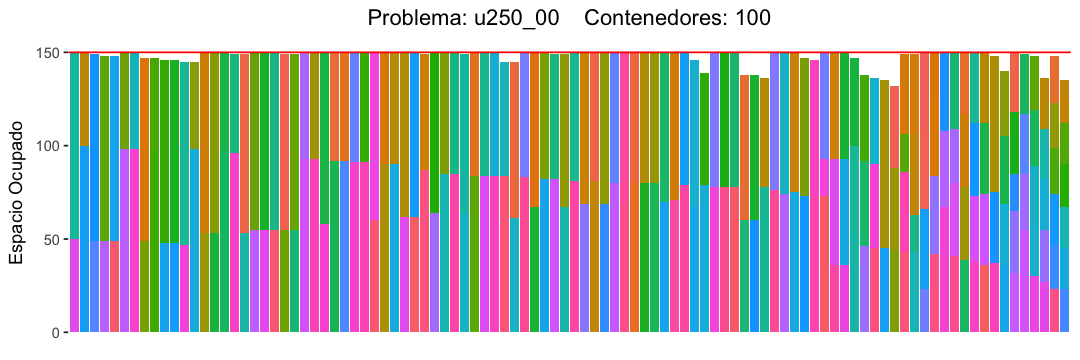

In [51]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u250_00.dat")) %>% 
PlotBinPacking() 

##### u250.01

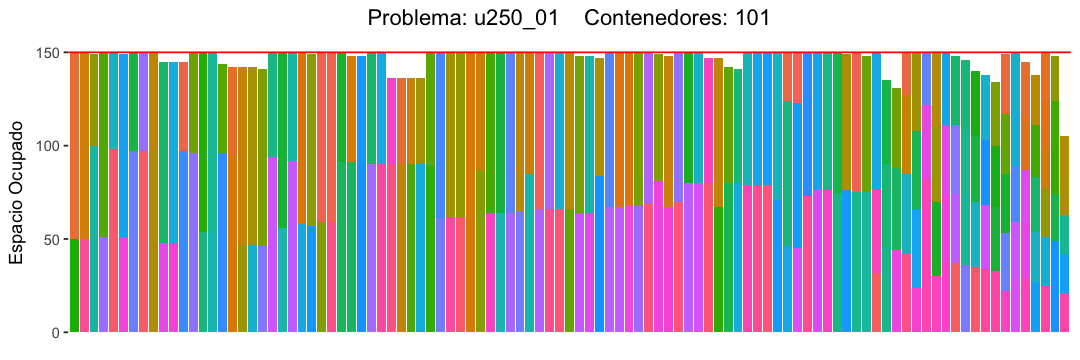

In [52]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u250_01.dat")) %>% 
PlotBinPacking() 

##### u250.02

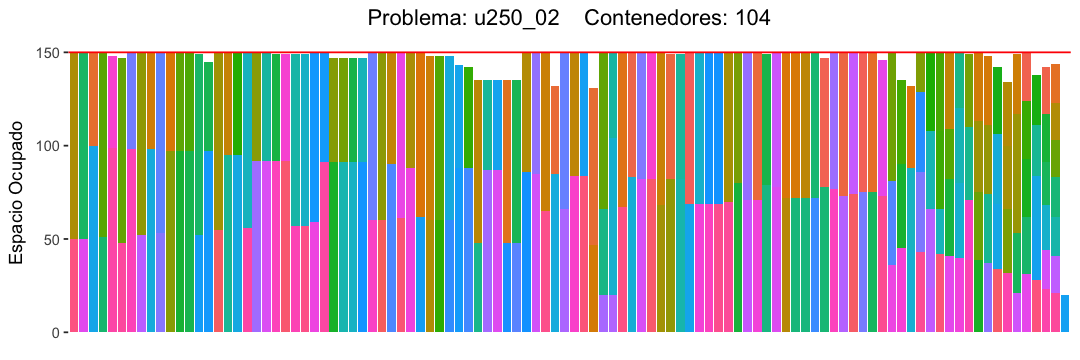

In [53]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u250_02.dat")) %>%
PlotBinPacking() 

##### u500.00

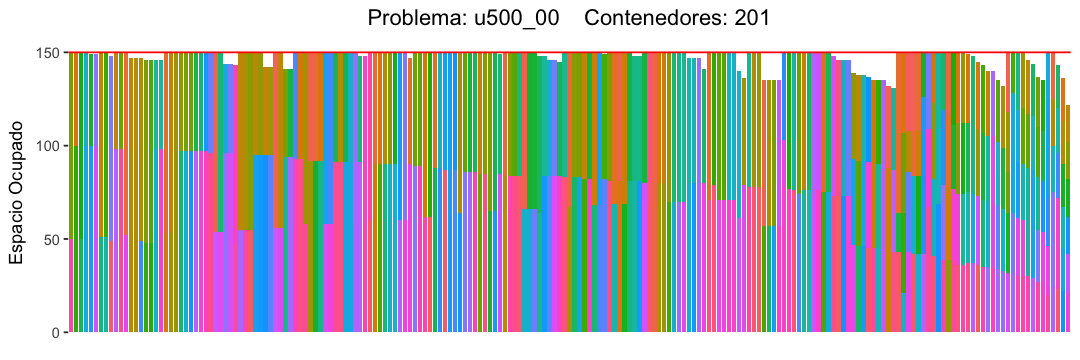

In [54]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u500_00.dat")) %>% 
PlotBinPacking() 

##### u500.01

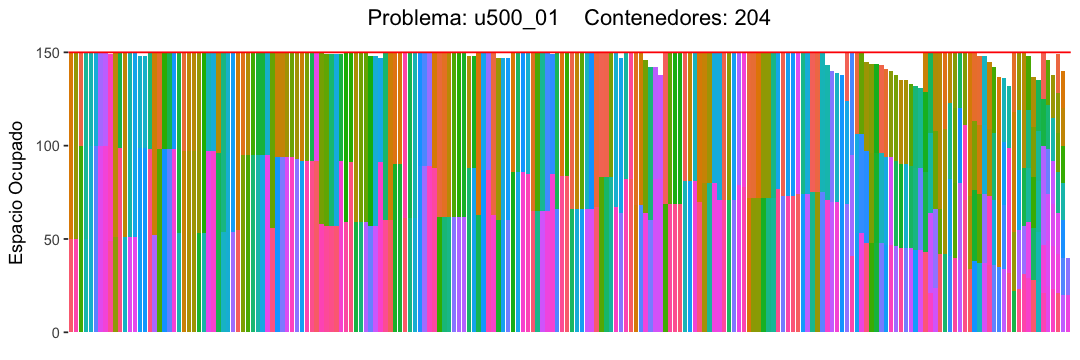

In [55]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u500_01.dat")) %>% 
PlotBinPacking() 

##### u500.02

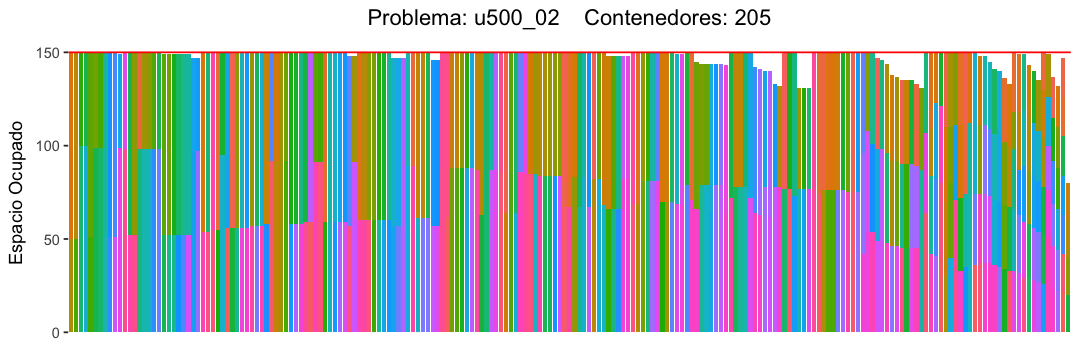

In [56]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u500_02.dat")) %>% 
PlotBinPacking() 

## Conclusiones

TODO

## Referencias

  * [TRC13] Team, R.C., 2013. R: A language and environment for statistical computing.
  * [GP18] Sergio García Prado. Programación Entera: Heurísticas, 2018. [github.com/garciparedes/integer-programming-heuristics](https://github.com/garciparedes/integer-programming-heuristics).
  * [SA18] Jesús Sáez Aguado. Programación Entera, 2017/18. Facultad de Ciencias: Departamento de Estadística e Investigación Operativa.
  * [THBSST17] Theussl, S., Hornik, K., Buchta, C., Schwendinger, F., Schuchardt, H. and Theussl, M.S., 2017. Package ‘Rglpk’.
  